## FORECASTING USING ARMA

In [1]:
#IMPORTING LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import SimpleExpSmoothing
from statsmodels.tsa.api import ExponentialSmoothing

import warnings
warnings.filterwarnings('ignore')
# dickey fuller test for stationarity check
from statsmodels.tsa.stattools import adfuller,acf,pacf

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\Admin\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


##### TASK 1 - DATA PREPARATION

In [2]:
#IMPORTING DATASET
train_df=pd.read_csv('DS3_C1_S3_DailyDelhiClimateTrain_Data_Practice.csv',index_col='date',parse_dates=True)
test_df=pd.read_csv('DS3_C1_S3_DailyDelhiClimateTest_Data_Practice.csv',index_col='date',parse_dates=True)
print('TRAIN:',train_df.shape,'\nTEST:',test_df.shape)
train_df.head(2),test_df.head(2)

TRAIN: (1462, 4) 
TEST: (114, 4)


(            meantemp  humidity  wind_speed  meanpressure
 date                                                    
 2013-01-01      10.0      84.5        0.00   1015.666667
 2013-01-02       7.4      92.0        2.98   1017.800000,
              meantemp   humidity  wind_speed  meanpressure
 date                                                      
 2017-01-01  15.913043  85.869565    2.743478     59.000000
 2017-01-02  18.500000  77.222222    2.894444   1018.277778)

In [3]:
train_temp=train_df[['meantemp']]
train_temp.head(2)

,meantemp
date,
2013-01-01,10.0
2013-01-02,7.4


In [4]:
test_temp=test_df[['meantemp']]
test_temp.head(2)

,meantemp
date,
2017-01-01,15.913043
2017-01-02,18.500000


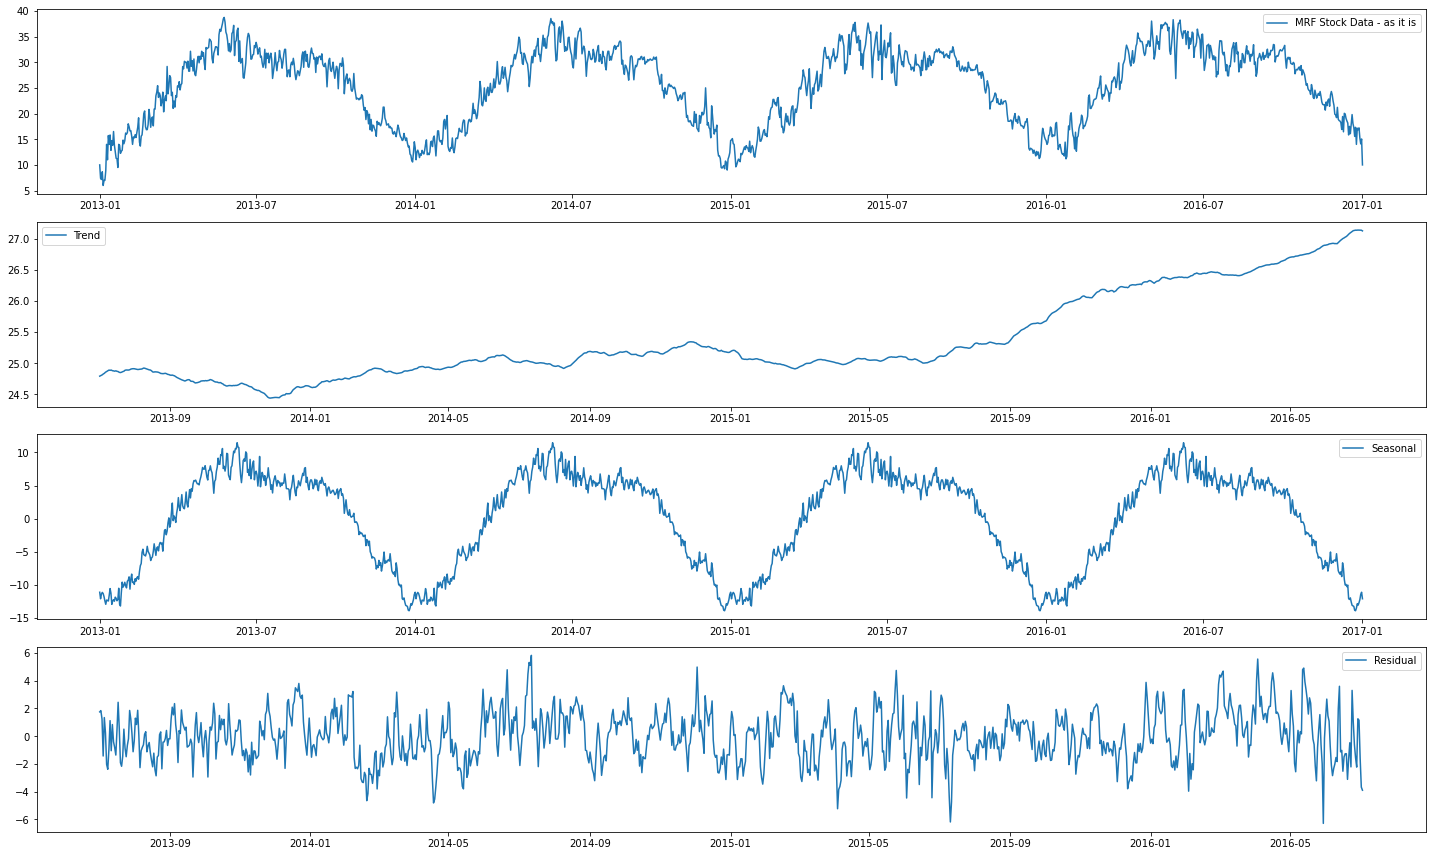

In [5]:
# different components of the Time series data

decomposition=seasonal_decompose(train_temp, period=365)
d_trend=decomposition.trend
d_seasonal=decomposition.seasonal
d_residual=decomposition.resid

# plotting all the 4 graphs
fig,ax = plt.subplots(4,1,figsize=(20,12))

plt.subplot(411)
plt.plot(train_temp,label='MRF Stock Data - as it is')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(d_trend,label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(d_seasonal,label='Seasonal')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(d_residual,label='Residual')
plt.legend(loc='best')

plt.tight_layout()

There is trend and seasonality in this data

##### SMOOTHING

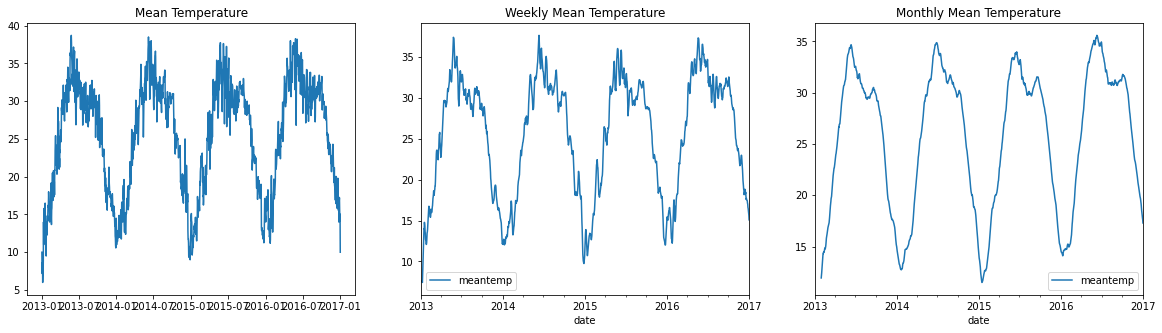

In [6]:
#TRAINING
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].plot(train_temp)
ax[0].set_title('Mean Temperature')
train_temp.rolling(window=7).mean().plot(ax=ax[1])
ax[1].set_title('Weekly Mean Temperature')
train_temp.rolling(window=30).mean().plot(ax=ax[2])
ax[2].set_title('Monthly Mean Temperature')
plt.show()

In [7]:
#choosing weekly smoothing
train_temp1=train_temp.rolling(window=7).mean()
train_temp1.dropna(inplace=True)
train_temp1

,meantemp
date,
2013-01-07,7.604762
2013-01-08,7.441497
2013-01-09,8.384354
2013-01-10,8.931973
2013-01-11,9.938776
...,...
2016-12-28,16.480592
2016-12-29,16.188075
2016-12-30,15.980252


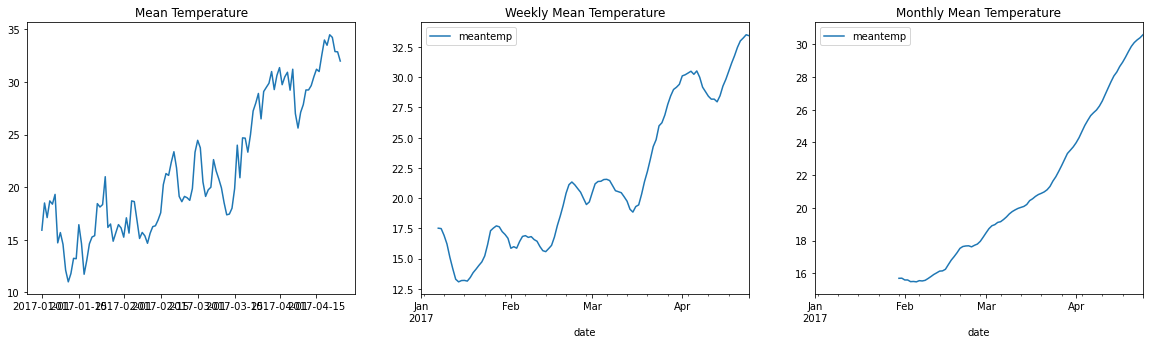

In [28]:
#TESTING
fig,ax=plt.subplots(1,3,figsize=(20,5))
ax[0].plot(test_temp)
ax[0].set_title('Mean Temperature')
test_temp.rolling(window=7).mean().plot(ax=ax[1])
ax[1].set_title('Weekly Mean Temperature')
test_temp.rolling(window=30).mean().plot(ax=ax[2])
ax[2].set_title('Monthly Mean Temperature')
plt.show()

In [9]:
#choosing weekly smoothing
test_temp1=test_temp.rolling(window=7).mean()
test_temp1.dropna(inplace=True)
test_temp1

,meantemp
date,
2017-01-07,17.519937
2017-01-08,17.487247
2017-01-09,16.926022
2017-01-10,16.211736
2017-01-11,15.111736
...,...
2017-04-20,32.468254
2017-04-21,33.003968
2017-04-22,33.243651


##### TASK 2 - STATIONARITY

In [10]:
# Augmented dickey-fuller test for stationarity
def checkStationarity(data):
    pvalue = adfuller(data)[1]

    if(pvalue>0.05):
        msg = 'p-value={}. Data is not stationary'.format(pvalue)
    else:
        msg='p-value={}. Data is stationary'.format(pvalue)
        
    return(msg)

In [11]:
#TRAINING
# check the data for stationarity
r=checkStationarity(train_temp1)
print(r)
# difference in the data 
diff_train_temp = train_temp1 - train_temp1.shift()
print(diff_train_temp)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff_train_temp))
diff_train_temp.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff_train_temp))
print(diff_train_temp)
# checking again the differenced data for stationarity
checkStationarity(diff_train_temp)

p-value=0.07252386116400802. Data is not stationary
            meantemp
date                
2013-01-07       NaN
2013-01-08 -0.163265
2013-01-09  0.942857
2013-01-10  0.547619
2013-01-11  1.006803
...              ...
2016-12-28 -0.118944
2016-12-29 -0.292517
2016-12-30 -0.207823
2016-12-31 -0.323650
2017-01-01 -0.571429

[1456 rows x 1 columns]
Before removing Nulls,total records =  1456
After removing Nulls, total records =  1455
            meantemp
date                
2013-01-08 -0.163265
2013-01-09  0.942857
2013-01-10  0.547619
2013-01-11  1.006803
2013-01-12  1.142857
...              ...
2016-12-28 -0.118944
2016-12-29 -0.292517
2016-12-30 -0.207823
2016-12-31 -0.323650
2017-01-01 -0.571429

[1455 rows x 1 columns]


'p-value=4.186610393547038e-06. Data is stationary'

						ACTUAL VS DIFFERENCED DATA


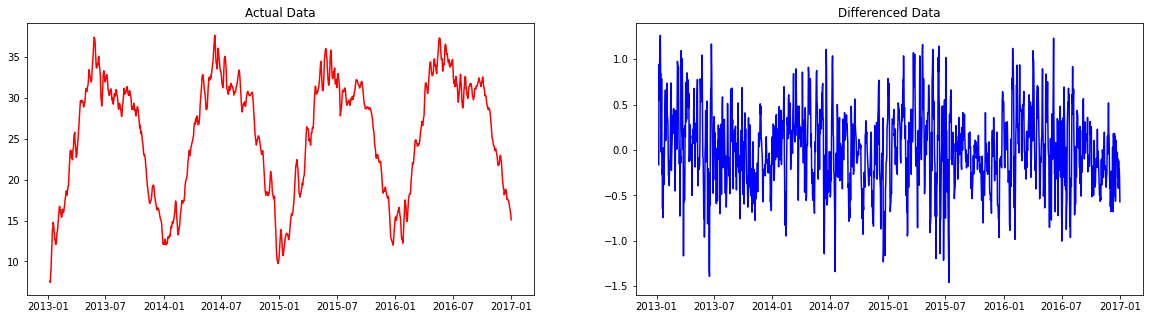

In [12]:
#TRAINING
# plot the Actual data and Differenced data
plt.figure(figsize=(20,5))
print('\t\t\t\t\t\tACTUAL VS DIFFERENCED DATA')
plt.subplot(121)
plt.plot(train_temp1,color='red')
plt.title('Actual Data')

plt.subplot(122)
plt.plot(diff_train_temp,color='blue')
plt.title('Differenced Data')

plt.show()

In [13]:
#TESTING
# check the data for stationarity
r=checkStationarity(test_temp1)
print(r)
# difference in the data 
diff_test_temp = test_temp1 - test_temp1.shift()
print(diff_test_temp)
# remove the Nulls from the differenced data
print('Before removing Nulls,total records = ', len(diff_test_temp))
diff_test_temp.dropna(inplace = True)
print('After removing Nulls, total records = ', len(diff_test_temp))
print(diff_test_temp)
# checking again the differenced data for stationarity
checkStationarity(diff_test_temp)

p-value=0.9359121007070483. Data is not stationary
            meantemp
date                
2017-01-07       NaN
2017-01-08 -0.032690
2017-01-09 -0.561224
2017-01-10 -0.714286
2017-01-11 -1.100000
...              ...
2017-04-20  0.690476
2017-04-21  0.535714
2017-04-22  0.239683
2017-04-23  0.267857
2017-04-24 -0.079365

[108 rows x 1 columns]
Before removing Nulls,total records =  108
After removing Nulls, total records =  107
            meantemp
date                
2017-01-08 -0.032690
2017-01-09 -0.561224
2017-01-10 -0.714286
2017-01-11 -1.100000
2017-01-12 -0.942774
...              ...
2017-04-20  0.690476
2017-04-21  0.535714
2017-04-22  0.239683
2017-04-23  0.267857
2017-04-24 -0.079365

[107 rows x 1 columns]


'p-value=0.04284624441674329. Data is stationary'

						ACTUAL VS DIFFERENCED DATA


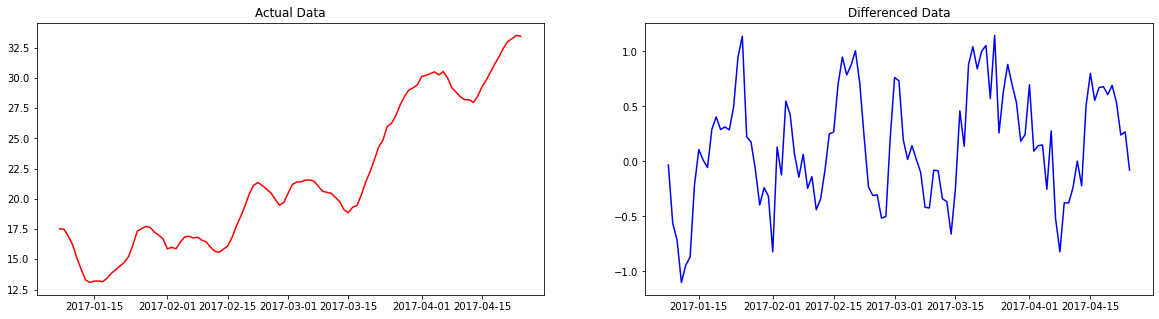

In [14]:
#TESTING
# plot the Actual data and Differenced data
plt.figure(figsize=(20,5))
print('\t\t\t\t\t\tACTUAL VS DIFFERENCED DATA')
plt.subplot(121)
plt.plot(test_temp1,color='red')
plt.title('Actual Data')

plt.subplot(122)
plt.plot(diff_test_temp,color='blue')
plt.title('Differenced Data')

plt.show()

##### TASK 3 - FORECASTING

##### PLOT ACF AND PACF

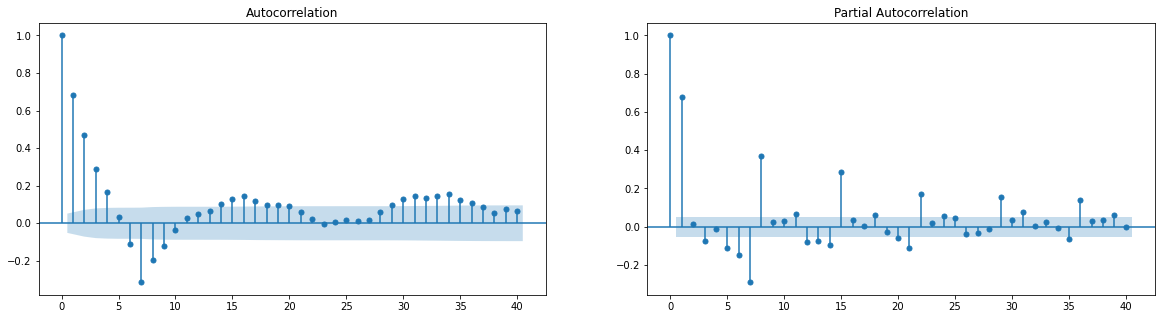

In [15]:
fig,ax=plt.subplots(1,2,figsize=(20,5))
plot_acf(diff_train_temp,lags=40,ax=ax[0])
plot_pacf(diff_train_temp,lags=40,ax=ax[1])
plt.show()

##### ARMA MODEL

In [16]:
# start with initial values for p and q
for p in range(2,4):
    for q in range(1,3):
        print('p=',p,'q=',q)
        m = ARIMA(diff_train_temp,order=(p,0,q)).fit()
        print(m.summary())

p= 2 q= 1
                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1455
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -356.574
Date:                Wed, 27 Apr 2022   AIC                            723.147
Time:                        12:03:55   BIC                            749.561
Sample:                    01-08-2013   HQIC                           733.002
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0041      0.027      0.155      0.877      -0.048       0.056
ar.L1         -0.2367      0.035     -6.842      0.000      -0.304      -0.169
ar.L2          0.6632      0.021     31.23

Selecting (p,q)=(3,2) as it satisifies both the criteria where LLR is high and Information criteria is less



In [17]:
#AR=3-->p MA=2-->q
m1 = ARIMA(diff_train_temp,order=(3,0,2)).fit()
print(m1.summary())

                               SARIMAX Results                                
Dep. Variable:               meantemp   No. Observations:                 1455
Model:                 ARIMA(3, 0, 2)   Log Likelihood                -252.545
Date:                Wed, 27 Apr 2022   AIC                            519.091
Time:                        12:04:01   BIC                            556.070
Sample:                    01-08-2013   HQIC                           532.888
                         - 01-01-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0027      0.024      0.113      0.910      -0.045       0.050
ar.L1          0.2772      0.022     12.431      0.000       0.234       0.321
ar.L2         -0.4637      0.019    -24.851      0.0

##### PREDICTING TEMPERATURE OF TEST DATA USING MODEL

In [18]:
predictions = m1.predict(0,len(diff_test_temp))
print(predictions)

2013-01-08    0.002734
2013-01-09   -0.110326
2013-01-10    0.648648
2013-01-11    0.493548
2013-01-12    0.550071
                ...   
2013-04-21    0.242995
2013-04-22   -0.047785
2013-04-23   -0.323360
2013-04-24   -0.267351
2013-04-25    0.238261
Freq: D, Name: predicted_mean, Length: 108, dtype: float64


In [19]:
diff_test_temp.shape,predictions.shape

((107, 1), (108,))

In [20]:
# actual vs predicted values
actual = []; pred = []

for i in range(len(diff_test_temp)):
    actual.append(diff_test_temp.iloc[i][0])
    pred.append(predictions[i])

df_res = pd.DataFrame({'actual':actual, 'predicted':pred})
df_res['err'] = df_res.actual - df_res.predicted
print(df_res)

       actual  predicted       err
0   -0.032690   0.002734 -0.035424
1   -0.561224  -0.110326 -0.450898
2   -0.714286   0.648648 -1.362934
3   -1.100000   0.493548 -1.593548
4   -0.942774   0.550071 -1.492845
..        ...        ...       ...
102  0.690476  -0.122373  0.812849
103  0.535714   0.242995  0.292719
104  0.239683  -0.047785  0.287468
105  0.267857  -0.323360  0.591217
106 -0.079365  -0.267351  0.187986

[107 rows x 3 columns]


##### PLOTTING ACTUAL AND PREDICTED DATA

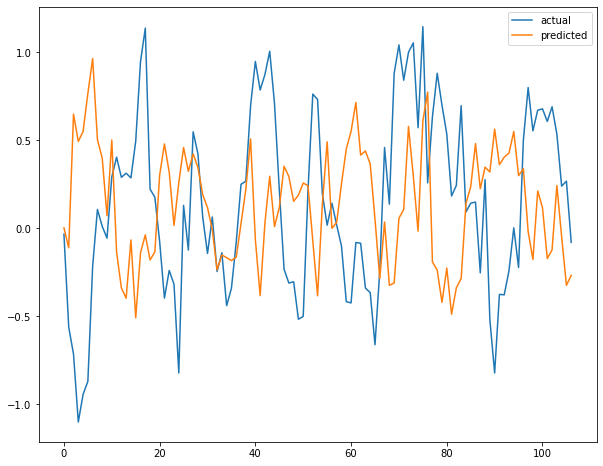

In [21]:
df_res.actual.plot(figsize=(10,8),legend=True)
df_res.predicted.plot(legend=True)
plt.show()

##### EVALUATION METRIC

In [22]:
# MSE & RMSE
msg = 'ARMA Model. Order=(' + str(p) + ',' + str(q) + ')'
mse1 = mean_squared_error(df_res.actual, df_res.predicted)
print(msg + "\n\tMSE = {}\n\tRMSE = {}".format(mse1,np.sqrt(mse1)))

ARMA Model. Order=(3,2)
	MSE = 0.4798359602658183
	RMSE = 0.6927019274304196


##### RESIDUAL PLOT

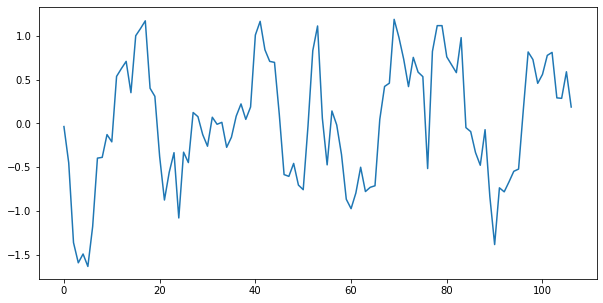

In [23]:
plt.figure(figsize=(10,5))
plt.plot(df_res.err)
plt.show()

In [24]:
#SUMMARY STATISTICS
df_res.err.describe()

count    107.000000
mean       0.014390
std        0.695812
min       -1.635266
25%       -0.489286
50%        0.046732
75%        0.589299
max        1.190744
Name: err, dtype: float64

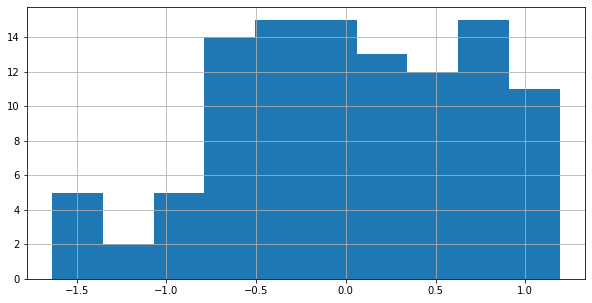

In [25]:
#RESIDUAL-HISTOGRAM
plt.figure(figsize=(10,5))
df_res.err.hist()
plt.show()

In [26]:
# LJung-Box test
pvalue = sm.stats.acorr_ljungbox(m1.resid,lags=[1],return_df=True)['lb_pvalue'].values
if pvalue < 0.05:
    print("Reject H0. Bad model")
else:
    print("Fail-to-Reject H0. Good model")

Fail-to-Reject H0. Good model


In [27]:
#END